In [40]:
from torchvision import models
from torchvision.models import ResNet50_Weights
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, ConcatDataset, Subset
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.ops import DropBlock2d
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import time 
import pathlib
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score


In [69]:
class augmented_dataset(Dataset):
    def __init__(self, targ_dir):
        self.paths = list(pathlib.Path(targ_dir).glob("*.jpg"))
        self.classes = ['Correct']
        self.class_to_idx = {'Classes':0}
        self.data = [(img, 'augm1') for img in self.paths]
        self.data.extend([(img, 'augm2') for img in self.paths])
        self.data.extend([(img, 'augm3') for img in self.paths])
        self.transform1 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.ColorJitter(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
        self.transform2 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
        self.transform3 = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.RandomRotation(1),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):

        if self.data[i][1] == 'augm1':
            img = Image.open(self.data[i][0])
            img = self.transform1(img)

        if self.data[i][1] == 'augm2':
            img = Image.open(self.data[i][0])
            img = self.transform2(img)

        if self.data[i][1] == 'augm3':
            img = Image.open(self.data[i][0])
            img = self.transform3(img)              

        return img,0

#train and test data directory
data_dir = "PetImages/RevisitedTraining"
correct_label_dir = "PetImages/RevisitedTraining/Correct"

dataset = ImageFolder(data_dir, transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

test = augmented_dataset(correct_label_dir)
print("OOga",len(test))
item1, lab1 = test[0]
# print(item1)

# print("Classes", (dataset.class_to_idx), (dataset.classes))
print(len(dataset))
t1, l1 = dataset[0]
# print(t1)

concat_dataset = ConcatDataset([dataset, test])
print(len(concat_dataset))


#Manually inputting correct proportions of values
size = 3000
correctsub = torch.randperm(len(test))[:size-1000]
incorrectsub = torch.randperm(len(dataset))[:size]
part1_subset = Subset(test, correctsub)
part2_subset = Subset(dataset,incorrectsub)
new_subset = ConcatDataset([part1_subset,part2_subset])
n = len(new_subset)
print("New subset length",n)
n_train = int(0.8 * n)
train, valid = random_split(new_subset, [n_train, n-n_train])
n2 = len(train)
n_test = int(0.8*n2)
train, test = random_split(train, [n_test, n2-n_test])
print("Train Len", len(train))
print("Valid Len", len(valid))
print("Test Len", len(test))


n_test = 1000

train_data_size = len(train)
valid_data_size = len(valid)
test_data_size = len(test)


#Loading training and testing set into batches
train_dl = DataLoader(train, batch_size=64, num_workers=0, shuffle=True)
valid_dl = DataLoader(valid, batch_size=64, num_workers=0, shuffle=False)
test_dl = DataLoader(valid, batch_size=64, num_workers=0, shuffle=False)


OOga 33216
112482
145698
New subset length 5000
Train Len 3200
Valid Len 1000
Test Len 800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


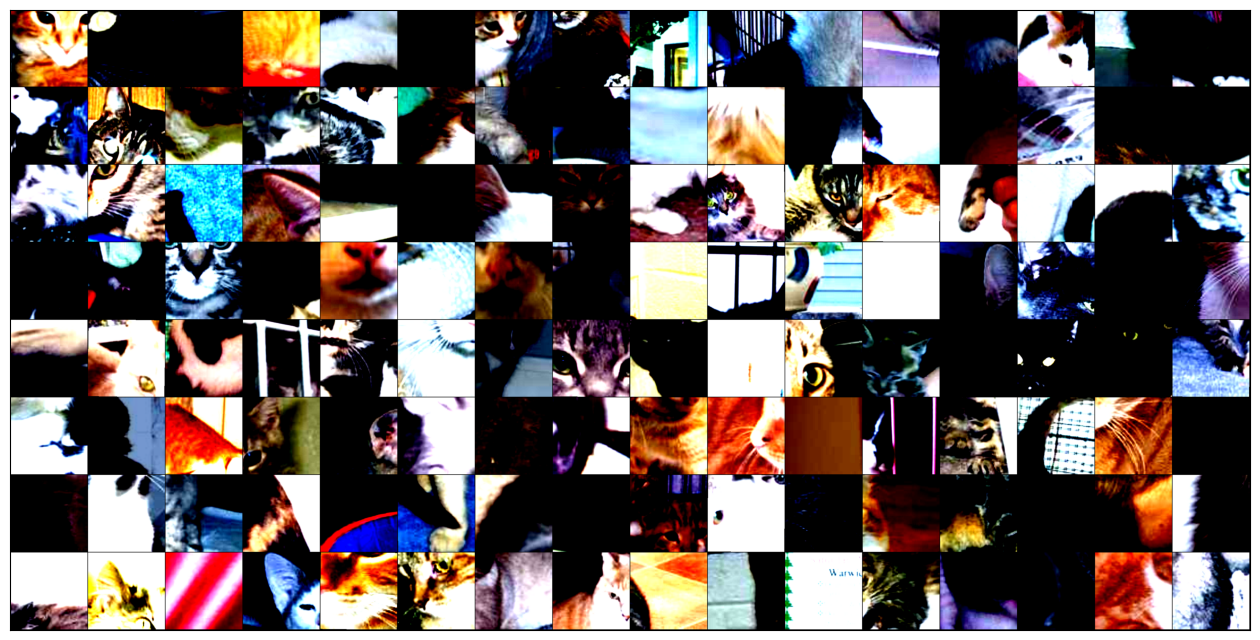

In [28]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [70]:
# Setup GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining checkpoints in training
def checkpoint(model, filename):
    torch.save({
        # 'epoch': current_epoch,
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        # 'loss': loss
    }, filename)

# Resuming the model with the states intact
def resume(model, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

# Loading pretrained model
pretrained_model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)

# Freeze model parameters
for param in pretrained_model.parameters():
    param.requires_grad = False

# Changing final layer of ResNet50 model for transfer learning
fc_inputs = pretrained_model.classifier[1].in_features
print("FC INPUT SIZE - ",fc_inputs)
pretrained_model.classifier = nn.Sequential(
    # nn.Linear(fc_inputs, 2),
    nn.Dropout(0.5),
    nn.Linear(fc_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
    # nn.Sigmoid()
)

# Convert model for use on GPU
pretrained_model = pretrained_model.to(device)

#Define Optimiser and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), weight_decay=1e-5)
# optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

def train_and_validate(model, loss_criterion, optimizer, epochs=20, start_epoch = 0):
    
    if start_epoch > 0:
        start_epoch -= 1
        print("Resuming at model_{}.pt".format(start_epoch))
        resume(model, f"model_{start_epoch}.pt")

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(start_epoch,epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_dl):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_dl):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save current model at each epoch for checkpoints
        path = 'model_'+str(epoch)+'.pt'
        checkpoint(model=model, filename=path)
        # torch.save(model.state_dict(),name)
            
    return model, history, best_epoch

# Training the model
# Setting the start_epoch variable will determine any checkpoint epoch to start training from
num_epochs = 10
start_epoch = 0

trained_model, history, best_epoch = train_and_validate(pretrained_model, loss_func, optimizer, num_epochs, start_epoch)
print("THE BEST",best_epoch)
torch.save(history, 'history.pt')

FC INPUT SIZE -  1408
Epoch: 1/10
Epoch : 001, Training: Loss - 0.6123, Accuracy - 66.9688%, 
		Validation : Loss - 0.5305, Accuracy - 73.9000%, Time: 104.6172s
Epoch: 2/10
Epoch : 002, Training: Loss - 0.5538, Accuracy - 72.0938%, 
		Validation : Loss - 0.4944, Accuracy - 77.9000%, Time: 24.0831s
Epoch: 3/10
Epoch : 003, Training: Loss - 0.5236, Accuracy - 74.1562%, 
		Validation : Loss - 0.4883, Accuracy - 76.5000%, Time: 24.1812s
Epoch: 4/10
Epoch : 004, Training: Loss - 0.5083, Accuracy - 75.5625%, 
		Validation : Loss - 0.4842, Accuracy - 78.4000%, Time: 24.5531s
Epoch: 5/10
Epoch : 005, Training: Loss - 0.5021, Accuracy - 74.7812%, 
		Validation : Loss - 0.4800, Accuracy - 79.3000%, Time: 24.9700s
Epoch: 6/10
Epoch : 006, Training: Loss - 0.4962, Accuracy - 75.5938%, 
		Validation : Loss - 0.4754, Accuracy - 78.8000%, Time: 24.5741s
Epoch: 7/10
Epoch : 007, Training: Loss - 0.4975, Accuracy - 75.6875%, 
		Validation : Loss - 0.4827, Accuracy - 77.0000%, Time: 24.7406s
Epoch: 8/10

Getting predictions from test set…


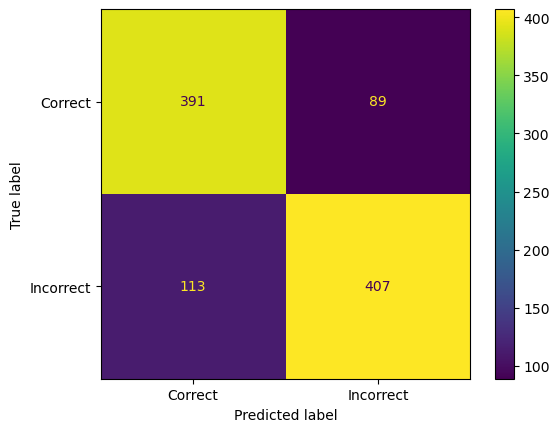

F1 Score:
0.7947154471544715


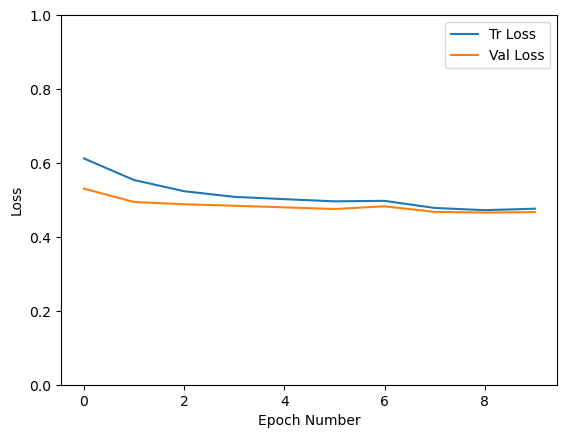

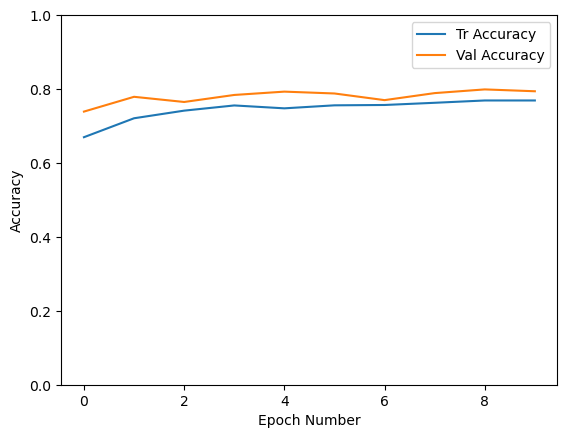

In [71]:
truelabels = []
predictions = []
trained_model.eval()
print("Getting predictions from test set…")
for data, target in valid_dl:
    data = data.to(device)
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in trained_model(data):
        predictions.append(torch.argmax(prediction).item())
labels = ["Correct", "Incorrect"]
cm = confusion_matrix(truelabels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print("F1 Score:")
f1 = f1_score(truelabels, predictions, pos_label=0,average='binary')
print(f1)

# Display Loss over training
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
# plt.savefig(dataset+'_loss_curve.png')
plt.show()

# Display accuracy over training
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [78]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

computeTestSetAccuracy(trained_model, nn.CrossEntropyLoss())

NameError: name 'test_data_loader' is not defined